# {FVCOM} R-Package Mesh Testing 

FVCOM is a bit finnicky because it is an unstructured grid. This makes using indexing methods and just loading it in general kind of a pain. There seem to be a number of ways to work with or work around this. Ben Tupper with Bigelow labs has created an R-package which does a good job at maintaining/representing the mesh using simple features which can be used as a streamlined way of clipping the nodes we care about while preserving the integrity of the mesh.

There is also a python library called uxarray, uxarray exists for working with unstructured grids, and has some promises of eventually working with FVCOM, but it is not clear how far along it is in development.

Here is a light-weight attempt at accessing/subsetting the data with with the help of these libraries. 

### UPDATE: 3/25/2024 - UXARRAY Does not Support

In [1]:
# Libraries
import xarray as xr
import numpy as np
import pandas as pd
import geopandas as gpd
import os
from dateutil import parser
from datetime import datetime,timedelta
import uxarray as ux
import matplotlib.pyplot as plt

# Set directory of where to save a manageable piece (relative path)
print(os.getcwd())

# Path to Box Assets
box_root = "/Users/akemberling/Library/CloudStorage/Box-Box/"
sf_root = f"{box_root}RES_Data/Shapefiles"
lob_ecol_path = f"{box_root}Mills Lab/Projects/Lobster ECOL"

/Users/akemberling/Documents/Repositories/Lobster-ECOL/py/FVCOM-prep


## Load NECOFS Data

I've done a lot with the gom3 hindcast, this seems like a good chance for practicing with the NECOFS gom4 output.

Filenames in the thredds catalog are a combination of month and year. NECOFS coverage starts in 2016 and extends through 2024.

In [2]:
# Create a URL list that we can iterate through:
# hopefully it doesn't fail on us in the middle and ruin everything

# Start Year
start_yr = 2016

# End Year
end_yr = 2016

# Basic Structures for the year and month components
all_months = np.arange(1,13)
all_years  = np.arange(start_yr, end_yr+1)

# Link base structure
base_url = "http://www.smast.umassd.edu:8080/thredds/dodsC/models/fvcom/NECOFS/Archive/NECOFS_GOM/"

# Generate all the URLs with a good old fashioned loop:
all_urls = []
for yr in all_years:
    yr_base = f"{base_url}{yr}/gom4_{yr}"
    
    for mon in all_months:
        yr_mon_ext = f"{yr_base}{mon:02d}.nc"
        all_urls.append(yr_mon_ext)


# Peak at the first few URLS
all_urls[0:2]

['http://www.smast.umassd.edu:8080/thredds/dodsC/models/fvcom/NECOFS/Archive/NECOFS_GOM/2016/gom4_201601.nc',
 'http://www.smast.umassd.edu:8080/thredds/dodsC/models/fvcom/NECOFS/Archive/NECOFS_GOM/2016/gom4_201602.nc']

### Load a Day of NECOFS Data Xarray & as an unstructured grid with UXARRAY

In [3]:
# Load one day:
# Just need date and coords
ds = xr.open_dataset(
    f"{all_urls[0]}",
    decode_times = False)
ds

# convert lon/c, lat/c to coordinates
ds = ds.assign_coords({var:ds[var] for var in ['lon','lat','lonc','latc']})

# Fix time to see what the thirty years is:
# the first day
dt0 = parser.parse(ds.time.attrs['units'].replace('days since ',''))

# parse dates summing days to the origin
ds = ds.assign(time = [dt0 + timedelta(seconds = day * 86400) for day in ds.time.values])
ds

/Users/akemberling/opt/anaconda3/envs/fvcom_env/lib/python3.9/site-packages/xarray/coding/times.py:170: SerializationWarning: Ambiguous reference date string: 00:00:00. The first value is assumed to be the year hence will be padded with zeros to remove the ambiguity (the padded reference date string is: 0000:00:00). To remove this message, remove the ambiguity by padding your reference date strings with zeros.
  warnings.warn(warning_msg, SerializationWarning)


<xarray.Dataset> Size: 96GB
Dimensions:        (nele: 99137, node: 53087, siglay: 40, siglev: 41, three: 3,
                    time: 744, maxnode: 11, maxelem: 9, four: 4)
Coordinates:
    x              (node) float32 212kB 1.7e+06 1.705e+06 ... 5.848e+05
    y              (node) float32 212kB 4.205e+05 4.149e+05 ... -1.28e+05
    lon            (node) float32 212kB ...
    lat            (node) float32 212kB ...
    lonc           (nele) float32 397kB ...
    latc           (nele) float32 397kB ...
    siglay         (siglay, node) float32 8MB ...
    siglev         (siglev, node) float32 9MB ...
  * time           (time) datetime64[ns] 6kB 2016-01-01 ... 2016-01-31T22:58:...
Dimensions without coordinates: nele, node, three, maxnode, maxelem, four
Data variables: (12/47)
    nprocs         int32 4B ...
    partition      (nele) int32 397kB ...
    xc             (nele) float32 397kB ...
    yc             (nele) float32 397kB ...
    h              (node) float32 212kB ...
    nv             (three, nele) int32 1MB ...
    ...             ...
    vwind_stress   (time, nele) float32 295MB ...
    icing_0kts     (time, node) float32 158MB ...
    icing_10kts    (time, node) float32 158MB ...
    icing_wndx     (time, node) float32 158MB ...
    icing_wndy     (time, node) float32 158MB ...
    icing_satmp    (time, node) float32 158MB ...
Attributes: (12/20)
    title:                           FVCOM GOM NECOFS HINDCAST UPDATE
    institution:                     School for Marine Science and Technology
    source:                          FVCOM_3.0
    history:                         Tue Mar 29 14:06:16 2016: ncrcat -d time...
    references:                      http://fvcom.smast.umassd.edu, http://co...
    Conventions:                     CF-1.0
    ...                              ...
    Icing_Model_Forcing:             FVCOM variable surface icing forcing:\nF...
    Special_Physical_processes:      long shore flow adjustment for thermal w...
    nco_openmp_thread_number:        1
    DODS.strlen:                     26
    DODS.dimName:                    DateStrLen
    DODS_EXTRA.Unlimited_Dimension:  time

# Load Mesh Subset of Interest 

The following polygon contains node and zonal element ID's for an area we're interested in. These Node/Element Indices should capable of for use in subsetting the dat we want directly:

If we know what mesh elements we want for each area from using the FVCOM R package, we might be able to pass these values in to ds.sel()

<Axes: >

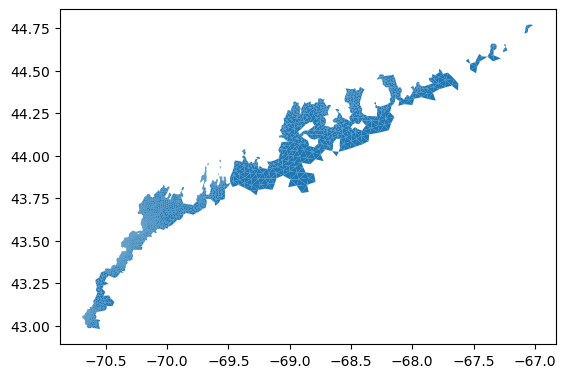

In [4]:
# Load the Inshore Area's  Mesh
vts_mesh = gpd.read_file(f"{lob_ecol_path}/FVCOM_support/VTSSurvey_FVCOM_nodes.geojson")
vts_mesh.plot()

In [5]:
# Drop geometry and get unique element and node
mesh_df = vts_mesh.drop(columns = "geometry")
mesh_df.head()

# Use unique function to get the node and element ID's
node_ids = pd.melt(mesh_df.drop(columns = ["elem"]))["value"].unique()
elem_ids = mesh_df["elem"].unique()
node_ids[0:6]

# IDs start with 1, and in python indices start with 0, we have to subtract 1 from them all
py_node_ids = node_ids - 1
py_elem_ids = elem_ids - 1

## Subsetting Variables for the Area of Interest - NOTE, node ID's don't match


**The Plan:**
Use the node ID's from the mesh that we clipped to the VTS survey area. This is our spatial subsetting. Then use the first and last indices to subset surface and bottom measurements.

**The issue**
The node ID's that are generated from the fvcom package don't directly correspond to the lat/lon index orders.

In [6]:
# Subset the variables we care about
variables = [
    'temp',
    'salinity',
    'u', # Eastward Water Velocity
    'v'  # Northward Water Velocity
]

# Subset Check The nodes, elements
vts_trim = ds.isel(
    node = py_node_ids, 
    nele = py_elem_ids)[variables]
vts_trim

<xarray.Dataset> Size: 2GB
Dimensions:   (time: 744, siglay: 40, node: 2571, nele: 4178)
Coordinates:
    x         (node) float32 10kB 1.002e+06 9.984e+05 ... 8.834e+05 9.479e+05
    y         (node) float32 10kB 1.061e+05 1.108e+05 ... 6.709e+04 1.273e+05
    lon       (node) float32 10kB ...
    lat       (node) float32 10kB ...
    lonc      (nele) float32 17kB ...
    latc      (nele) float32 17kB ...
    siglay    (siglay, node) float32 411kB ...
  * time      (time) datetime64[ns] 6kB 2016-01-01 ... 2016-01-31T22:58:07.50...
Dimensions without coordinates: node, nele
Data variables:
    temp      (time, siglay, node) float32 306MB ...
    salinity  (time, siglay, node) float32 306MB ...
    u         (time, siglay, nele) float32 497MB ...
    v         (time, siglay, nele) float32 497MB ...
Attributes: (12/20)
    title:                           FVCOM GOM NECOFS HINDCAST UPDATE
    institution:                     School for Marine Science and Technology
    source:                          FVCOM_3.0
    history:                         Tue Mar 29 14:06:16 2016: ncrcat -d time...
    references:                      http://fvcom.smast.umassd.edu, http://co...
    Conventions:                     CF-1.0
    ...                              ...
    Icing_Model_Forcing:             FVCOM variable surface icing forcing:\nF...
    Special_Physical_processes:      long shore flow adjustment for thermal w...
    nco_openmp_thread_number:        1
    DODS.strlen:                     26
    DODS.dimName:                    DateStrLen
    DODS_EXTRA.Unlimited_Dimension:  time

### What does a map look like?

Plotting the FVCOM data using xarray is strange because of the way dimensions are stored, so for the sake of just seeing something, I'll pull out lat/lon and the values as numpy arrays.

Text(0.5, 1.0, 'Spatial Subsetting Seems Okay for Nodes/Centers')

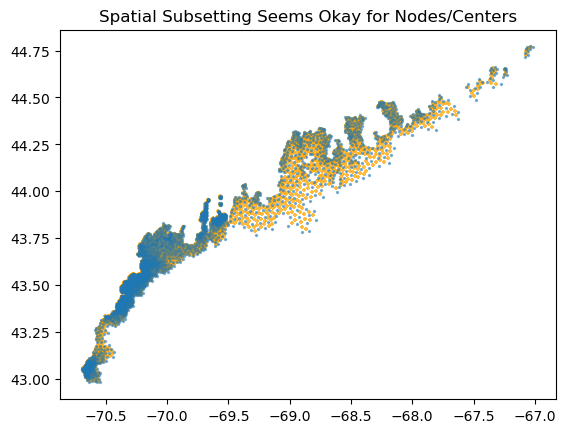

In [7]:
# Just grab the coordinates, tired of the dataset baggage
lon_vals = vts_trim.isel(time = 0, siglay = 0).lon.values
lat_vals = vts_trim.isel(time = 0, siglay = 0).lat.values
lonc_vals = vts_trim.isel(time = 0, siglay = 0).lonc.values
latc_vals = vts_trim.isel(time = 0, siglay = 0).latc.values

# Plot the coordinates
fig, ax = plt.subplots()  # Create a figure containing a single axes.
#vts_mesh.boundary.plot(ax = ax, color = "gray", alpha = 0.15)
ax.scatter(lonc_vals, latc_vals,  marker = "+", s = 5, color = "orange", alpha = 0.75)
ax.scatter(lon_vals, lat_vals, s = 2, alpha = 0.5)
ax.set_title("Spatial Subsetting Seems Okay for Nodes/Centers")  # Add a title to the axes.

### Plotting Surface vs. Bottom Conditions

Now that we can confirm that the area is correct, lets look at what the surface and bottom conditions look like to confirm that we can index depth sigmas as we intend to:

Text(0.5, 1.0, 'Bottom Temp')

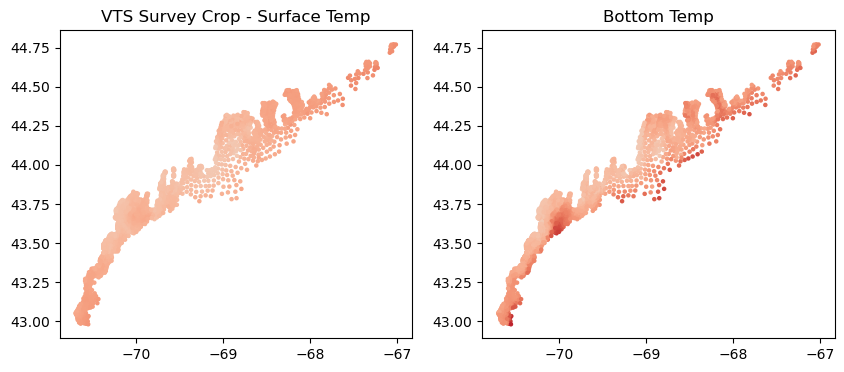

In [8]:
# Can we pull out the minimal info: 
#surface: lat/lon + temp & salinity, latc/lonc + u & v
vts_surface = vts_trim.isel(siglay = 0, time = 0)

# Bottom layer: index for siglev/siglay = -1
# Bottom: lat/lon + temp & salinity
vts_bottom = vts_trim.isel(siglay = -1, time = 0)[['temp','salinity']]

# plot temperatures
# Plot the coordinates
fig, ax = plt.subplots(1,2, figsize=(10, 4))  # Create a figure containing a single axes.
#vts_mesh.boundary.plot(ax = ax, color = "gray", alpha = 0.15)
ax[0].scatter(x = lon_vals, y = lat_vals,  c = vts_surface.temp, s = 5, cmap = "coolwarm", vmin = 2, vmax = 10)
ax[0].set_title("VTS Survey Crop - Surface Temp")  # Add a title to the axes.
ax[1].scatter(x = lon_vals, y = lat_vals,  c = vts_bottom.temp, s = 5, cmap = "coolwarm", vmin = 2, vmax = 10)
ax[1].set_title("Bottom Temp")  # Add a title to the axes.


---

# Earnest Attempt to Get Monthly Data

With the above confirmed, we need to test a full year, and see what sizing we get after performing a monthly average. 

This will require opening the full month's connection using xr.open_mfdataset. The we'll apply the same index and variable sub-setting. 

We can split out surface and bottom, then do monthly averages, and rename.

In [33]:
# Create a Monthly URL list that we can iterate through:
# hopefully it doesn't fail on us in the middle and ruin everything

# Start Year
start_yr = 2016

# End Year
end_yr = 2016

# Basic Structures for the year and month components
all_months = np.arange(1,13)
all_years  = np.arange(start_yr, end_yr+1)

# Link base structure
base_url = "http://www.smast.umassd.edu:8080/thredds/dodsC/models/fvcom/NECOFS/Archive/NECOFS_GOM/"

# Generate all the URLs with a good old fashioned loop:
all_urls = []
for yr in all_years:
    yr_base = f"{base_url}{yr}/gom4_{yr}"
    
    for mon in all_months:
        yr_mon_ext = f"{yr_base}{mon:02d}.nc"
        all_urls.append(yr_mon_ext)

all_urls


['http://www.smast.umassd.edu:8080/thredds/dodsC/models/fvcom/NECOFS/Archive/NECOFS_GOM/2016/gom4_201601.nc',
 'http://www.smast.umassd.edu:8080/thredds/dodsC/models/fvcom/NECOFS/Archive/NECOFS_GOM/2016/gom4_201602.nc',
 'http://www.smast.umassd.edu:8080/thredds/dodsC/models/fvcom/NECOFS/Archive/NECOFS_GOM/2016/gom4_201603.nc',
 'http://www.smast.umassd.edu:8080/thredds/dodsC/models/fvcom/NECOFS/Archive/NECOFS_GOM/2016/gom4_201604.nc',
 'http://www.smast.umassd.edu:8080/thredds/dodsC/models/fvcom/NECOFS/Archive/NECOFS_GOM/2016/gom4_201605.nc',
 'http://www.smast.umassd.edu:8080/thredds/dodsC/models/fvcom/NECOFS/Archive/NECOFS_GOM/2016/gom4_201606.nc',
 'http://www.smast.umassd.edu:8080/thredds/dodsC/models/fvcom/NECOFS/Archive/NECOFS_GOM/2016/gom4_201607.nc',
 'http://www.smast.umassd.edu:8080/thredds/dodsC/models/fvcom/NECOFS/Archive/NECOFS_GOM/2016/gom4_201608.nc',
 'http://www.smast.umassd.edu:8080/thredds/dodsC/models/fvcom/NECOFS/Archive/NECOFS_GOM/2016/gom4_201609.nc',
 'http://w

### Note: open_mfdataset issues

The coordinates of FVCOM make concatenation across time not work. This will restrict workflow to looping over months.

In [21]:
# Open all the datasets for the month:
# Load one day:
# Just need date and coords
ds = xr.open_dataset(
    all_urls[0],
    decode_times = False)
ds

# convert lon/c, lat/c to coordinates
ds = ds.assign_coords({var:ds[var] for var in ['lon','lat','lonc','latc']})

# Fix time to see what the thirty years is:
# the first day
dt0 = parser.parse(ds.time.attrs['units'].replace('days since ',''))

# parse dates summing days to the origin
ds = ds.assign(time = [dt0 + timedelta(seconds = day * 86400) for day in ds.time.values])
ds

Note:Caching=1


<xarray.Dataset> Size: 96GB
Dimensions:        (nele: 99137, node: 53087, siglay: 40, siglev: 41, three: 3,
                    time: 744, maxnode: 11, maxelem: 9, four: 4)
Coordinates:
    x              (node) float32 212kB 1.7e+06 1.705e+06 ... 5.848e+05
    y              (node) float32 212kB 4.205e+05 4.149e+05 ... -1.28e+05
    lon            (node) float32 212kB ...
    lat            (node) float32 212kB ...
    lonc           (nele) float32 397kB ...
    latc           (nele) float32 397kB ...
    siglay         (siglay, node) float32 8MB ...
    siglev         (siglev, node) float32 9MB ...
  * time           (time) datetime64[ns] 6kB 2016-01-01 ... 2016-01-31T22:58:...
Dimensions without coordinates: nele, node, three, maxnode, maxelem, four
Data variables: (12/47)
    nprocs         int32 4B ...
    partition      (nele) int32 397kB ...
    xc             (nele) float32 397kB ...
    yc             (nele) float32 397kB ...
    h              (node) float32 212kB ...
    nv             (three, nele) int32 1MB ...
    ...             ...
    vwind_stress   (time, nele) float32 295MB ...
    icing_0kts     (time, node) float32 158MB ...
    icing_10kts    (time, node) float32 158MB ...
    icing_wndx     (time, node) float32 158MB ...
    icing_wndy     (time, node) float32 158MB ...
    icing_satmp    (time, node) float32 158MB ...
Attributes: (12/20)
    title:                           FVCOM GOM NECOFS HINDCAST UPDATE
    institution:                     School for Marine Science and Technology
    source:                          FVCOM_3.0
    history:                         Tue Mar 29 14:06:16 2016: ncrcat -d time...
    references:                      http://fvcom.smast.umassd.edu, http://co...
    Conventions:                     CF-1.0
    ...                              ...
    Icing_Model_Forcing:             FVCOM variable surface icing forcing:\nF...
    Special_Physical_processes:      long shore flow adjustment for thermal w...
    nco_openmp_thread_number:        1
    DODS.strlen:                     26
    DODS.dimName:                    DateStrLen
    DODS_EXTRA.Unlimited_Dimension:  time

### Trim and Perform Temporal Aggregation

Now that we have all the data for the month, we'll want to subset the variables and sigma levels to get the minimum data for the time aggregation.

In [34]:
# Subset the variables we care about
variables = [
    'temp',
    'salinity',
    'u', # Eastward Water Velocity
    'v'  # Northward Water Velocity
]

# Subset Check The nodes, elements
vts_trim = ds.isel(
    node = py_node_ids, 
    nele = py_elem_ids)[variables]


# Can we pull out the minimal info: 
#surface: lat/lon + temp & salinity, latc/lonc + u & v
vts_surface = vts_trim.isel(siglay = 0)

# Bottom layer: index for siglev/siglay = -1
# Bottom: lat/lon + temp & salinity
vts_bottom = vts_trim.isel(siglay = -1)[['temp','salinity']]

## Perform Monthly Averaging

I think this can be done with either resample or with groupby. 

In [36]:
# Aggregate to monthly averages
surf_monthly = vts_surface.resample(time = "ME").mean()
bot_monthly = vts_bottom.resample(time = "ME").mean()

/Users/akemberling/opt/anaconda3/envs/fvcom_env/lib/python3.9/site-packages/xarray/core/groupby.py:532: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  index_grouper = pd.Grouper(
/Users/akemberling/opt/anaconda3/envs/fvcom_env/lib/python3.9/site-packages/xarray/core/groupby.py:532: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  index_grouper = pd.Grouper(


In [37]:
# Inspect
bot_monthly

<xarray.Dataset> Size: 72kB
Dimensions:   (time: 1, node: 2571)
Coordinates:
    x         (node) float32 10kB 1.002e+06 9.984e+05 ... 8.834e+05 9.479e+05
    y         (node) float32 10kB 1.061e+05 1.108e+05 ... 6.709e+04 1.273e+05
    lon       (node) float32 10kB ...
    lat       (node) float32 10kB ...
    siglay    (node) float32 10kB ...
  * time      (time) datetime64[ns] 8B 2016-01-31
Dimensions without coordinates: node
Data variables:
    temp      (time, node) float32 10kB 8.302 7.641 8.827 ... 5.889 6.032 6.212
    salinity  (time, node) float32 10kB 33.3 33.19 33.47 ... 32.49 29.37 32.54
Attributes: (12/20)
    title:                           FVCOM GOM NECOFS HINDCAST UPDATE
    institution:                     School for Marine Science and Technology
    source:                          FVCOM_3.0
    history:                         Tue Mar 29 14:06:16 2016: ncrcat -d time...
    references:                      http://fvcom.smast.umassd.edu, http://co...
    Conventions:                     CF-1.0
    ...                              ...
    Icing_Model_Forcing:             FVCOM variable surface icing forcing:\nF...
    Special_Physical_processes:      long shore flow adjustment for thermal w...
    nco_openmp_thread_number:        1
    DODS.strlen:                     26
    DODS.dimName:                    DateStrLen
    DODS_EXTRA.Unlimited_Dimension:  time